In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [7]:
# View all of the classes that automap found
print(Base.classes.keys())

['measurement', 'station']


In [8]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
most_recent_measurement = session.query(Measurement.date).order_by(desc(Measurement.date)).first()[0]
most_recent_measurement = [int(val) for val in most_recent_measurement.split('-')]
print(most_recent_measurement)

[2017, 8, 23]


[('USC00519397', '2016-08-23', 0.0), ('USC00519397', '2016-08-24', 0.08), ('USC00519397', '2016-08-25', 0.08), ('USC00519397', '2016-08-26', 0.0), ('USC00519397', '2016-08-27', 0.0), ('USC00519397', '2016-08-28', 0.01), ('USC00519397', '2016-08-29', 0.0), ('USC00519397', '2016-08-30', 0.0), ('USC00519397', '2016-08-31', 0.13), ('USC00519397', '2016-09-01', 0.0), ('USC00519397', '2016-09-02', 0.0), ('USC00519397', '2016-09-03', 0.0), ('USC00519397', '2016-09-04', 0.03), ('USC00519397', '2016-09-05', None), ('USC00519397', '2016-09-06', None), ('USC00519397', '2016-09-07', 0.05), ('USC00519397', '2016-09-08', 0.0), ('USC00519397', '2016-09-09', 0.03), ('USC00519397', '2016-09-10', 0.0), ('USC00519397', '2016-09-11', 0.05), ('USC00519397', '2016-09-12', 0.0), ('USC00519397', '2016-09-13', 0.02), ('USC00519397', '2016-09-14', 1.32), ('USC00519397', '2016-09-15', 0.42), ('USC00519397', '2016-09-16', 0.06), ('USC00519397', '2016-09-17', 0.05), ('USC00519397', '2016-09-18', 0.0), ('USC0051939

C:\Users\niels\AppData\Local\Temp\ipykernel_30936\3078366625.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot.set_xticklabels([


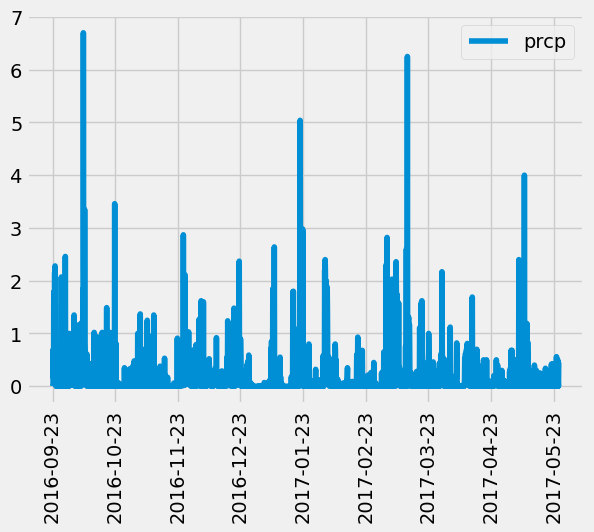

In [75]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
latest_date = dt.date(*most_recent_measurement)

# Calculate the date one year from the last date in data set.
one_year_ago_date = latest_date - dt.timedelta(days = 365)


# Perform a query to retrieve the data and precipitation scores
year_perc_data = session.\
    query(Measurement.station, Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago_date).\
    all()

print(year_perc_data)

# Save the query results as a Pandas DataFrame. Explicitly set the column names
percip_dataframe = pd.DataFrame({
    "station": [tup[0] for tup in year_perc_data],
    "msr_date" : [tup[1] for tup in year_perc_data],
    "prcp" : [tup[2] for tup in year_perc_data]
})

original_df = percip_dataframe.copy()

# Sort the dataframe by date
percip_dataframe.dropna(inplace=True)
percip_dataframe.sort_values(by=["msr_date"], inplace=True)
percip_dataframe.reset_index(inplace=True, drop=True)


# Use Pandas Plotting with Matplotlib to plot the data
plot = percip_dataframe.plot(
    kind="line"
)

plot.set_xticklabels([
    "2016-08-23",
    "2016-09-23",
    "2016-10-23",
    "2016-11-23",
    "2016-12-23",
    "2017-01-23",
    "2017-02-23",
    "2017-03-23",
    "2017-04-23",
    "2017-05-23",
    "2017-06-23",
    "2017-07-23",
    "2017-08-23",
], rotation=90)

plt.show()

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
percip_dataframe.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset
station_query = session.\
    query(Station.station, Station.latitude, Station.longitude, Station.elevation)

number_of_stations = pd.DataFrame({
    "station_id" : [tup[0] for tup in station_query],
    "msr_date" : [tup[1] for tup in station_query],
    "prcp" : [tup[2] for tup in station_query]
})

number_of_stations["station_id"].count()

9

In [24]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
stations_by_rows = session.\
    query(Measurement.station, func.count(Measurement.date)).\
    group_by(Measurement.station).\
    order_by(desc(func.count(Measurement.date))).\
    all()
stations_by_rows

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [59]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = stations_by_rows[0][0]
print(most_active_station_id)

mes_columns = ["date", "prcp", "tobs"]

active_station_values = session.\
    query(Measurement.date, Measurement.prcp, Measurement.tobs).\
    filter(Measurement.station == "USC00519281").\
    all()

active_station_values = pd.DataFrame(active_station_values, columns=mes_columns)

print(active_station_values)

active_metrics = {
    "lowest_temp" : active_station_values["tobs"].min(),
    "mean_temp" : active_station_values["tobs"].mean(),
    "highest_temp" : active_station_values["tobs"].max()
}

print(active_metrics)

USC00519281
            date  prcp  tobs
0     2010-01-01  0.15  70.0
1     2010-01-02  0.00  62.0
2     2010-01-03  0.00  74.0
3     2010-01-04  0.00  75.0
4     2010-01-05  0.00  74.0
...          ...   ...   ...
2767  2017-08-14  0.00  77.0
2768  2017-08-15  0.32  77.0
2769  2017-08-16  0.12  76.0
2770  2017-08-17  0.01  76.0
2771  2017-08-18  0.06  79.0

[2772 rows x 3 columns]
{'lowest_temp': 54.0, 'mean_temp': 71.66378066378067, 'highest_temp': 85.0}


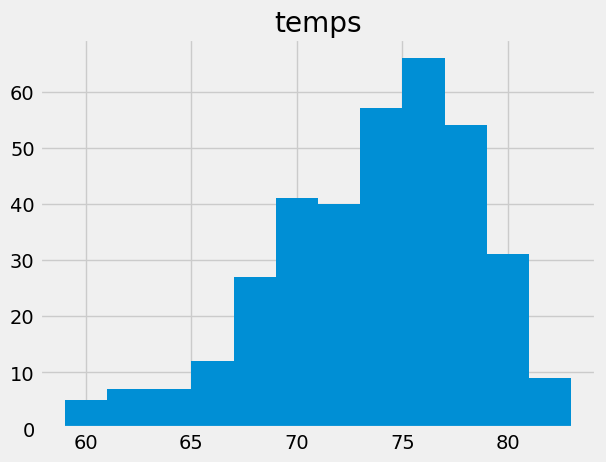

In [73]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
ma_most_recent_date = [int(val) for val in active_station_values["date"].max().split('-')]
ma_one_year_ago = dt.datetime(*ma_most_recent_date) - dt.timedelta(days = 365)

ma_last_year_data = session.\
    query(Measurement.date, Measurement.prcp, Measurement.tobs).\
    filter(Measurement.station == "USC00519281", Measurement.date >= ma_one_year_ago).\
    all()

ma_last_year_df = pd.DataFrame({
    "date" : [vals[0] for vals in ma_last_year_data],
    "temps" : [vals[2] for vals in ma_last_year_data],
})

fig, ax = plt.subplots(1, 1)

ma_last_year_df.hist(
    column="temps",
    bins=12,
    ax = ax
)

plt.show()

# Close Session

In [74]:
# Close Session
session.close()